# ALeRCE variable stars starter notebook, for new DB

```Authors: Alejandra Muñoz Arancibia, Lorena Hernandez Garcia, Last updated: 20200804```

ALeRCE starter notebook for variable stars science using the alerce client, API, and a direct database connection.
For more information about the ALeRCE broker, please visit http://alerce.science/

Note that this notebook uses the experimental ALeRCE API, which can be cloned and installed (`pip install -e .`) from https://github.com/alercebroker/alerce_client_new


# Table of contents:
* [Introduction](#intro)
* [Requirements](#req)
* [ALeRCE client](#client)
* [Query one target](#onetarget)
    * [Simple light curve](#simplelightcurve)
    * [Extinction corrected light curve](#advancedlightcurve)
    * [Simple period](#simpleperiod)
    * [Query image from Aladin](#oneimage)
* [Query a sample of targets](#sampletarget)
    * [Classifiers, taxonomies and numeric mappings in ALeRCE](#classifiers)
    * [Examples on how to use the ALeRCE client and database](#examplesample)
        * [Using the ALeRCE client to study a sample of RRL from their oid](#liuetal)
            * [Plot the light curves](#samplelightcurve)
            * [Plot the extinction corrected light curves](#sampleextlightcurve)
            * [Plot folded light curves and periodograms](#samplefoldedlightcurve)
            * [Plots of the sample properties](#asampleproperties)
            * [Query images from Aladin](#sampleimage)
            * [Estimate distances using the intensity-mean magnitude](#distances)
            * [Plots of the sample properties](#sampleproperties)
        * [Using the ALeRCE client to query a big sample of RRL](#clientrrl)
        * [Using the ALeRCE database (DB) to query a sample of RRL](#dbrrl)  

# Introduction <a class="anchor" id="intro"></a>

ALeRCE started to systematically classify the ZTF
stream using machine learning with astrophysically motivated taxonomies
based on their light curves (Sanchez-Saez et al. 2020)
since March 2019, and on their image stamps (Carrasco-Davis et al. 2020) since July 2019. These classfiers are designed to balance the needs for a fast and simple classification with a subsequent, but more complex classification.


The hierarchical taxonomy used by the ALeRCE broker for classifying light curves is shown in the figure below (v1.0.0). This classiffier uses
four models: one which separates transients, stochastic and periodic objects; another which separates transients into SNe Ia,
SNe Ib/c, SNe II and Superluminous SNe; another which separates stochastic objects into blazars, QSOs, AGNs and YSOs; and
another which classiffies periodic stars into LPVs, Ceph, RRL, DSCT, Es or Periodic-Other.
In total, the ALeRCE broker classifies objects into a taxonomy that has expanded into 15
classes, and with continuously improving precision and purity. Note that all of ALeRCE's data products can be accessed
freely via several dashboards, APIs, or a direct database connection.

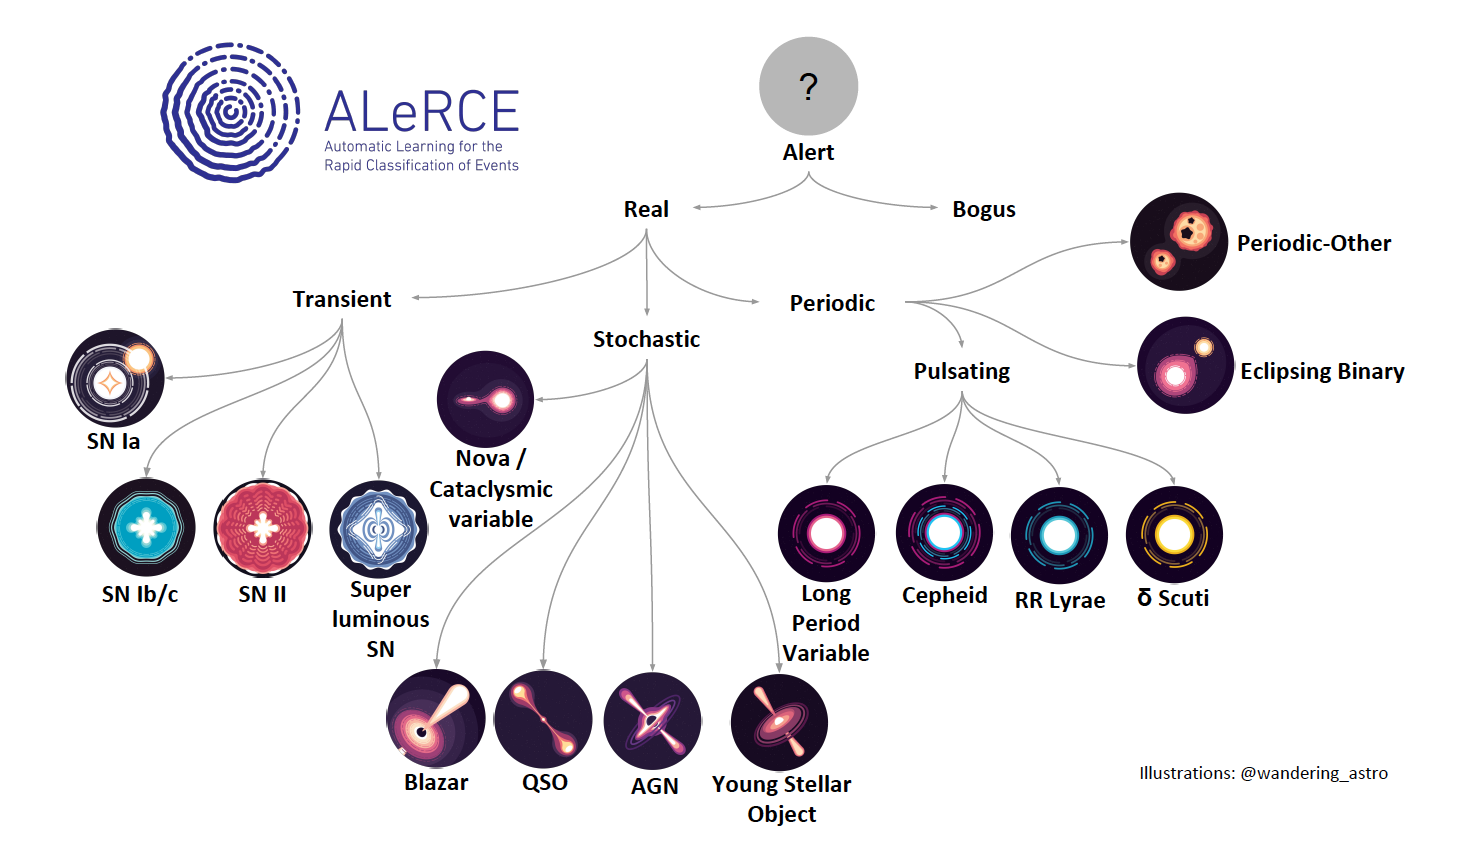

In this notebook we will query data from a single variable star in order to plot its light curve, which is the corrected by extinction. Because these stars are variable, we will plot their folded light curve and periodograms, thus we will be able to estimate their period. We will also see its image stamp, and visualize it in Aladin to explore its environment.

Then, we will show how to query a sample of variable stars using the ALeRCE client or the database (for big samples), showing their light curves and plotting different properties of the sample.

Documentation: You will need to install psycopg2, P4J, ipyaladin


# Requirements <a class="anchor" id="req"></a>

In the following we specify the required packages to run this Notebook. Some of the packages are included in Python and others require installation. Uncomment in case you need to install.

Basic Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Astropy and astroquery

In [2]:
#!pip install astroquery

In [3]:
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance
from astropy.cosmology import WMAP7
from astroquery.irsa_dust import IrsaDust
from astroquery.simbad import Simbad

Install psycopg2 https://github.com/psycopg/psycopg2

In [4]:
#!pip install psycopg2-binary

In [5]:
import psycopg2

Install P4J https://pypi.org/project/P4J/

In [6]:
#!git clone --depth=1 github.com/phuijse/P4J 
#!python setup.py install --user

In [7]:
import P4J

Install pyaladin https://github.com/cds-astro/ipyaladin

In [8]:
# you may need to restart the notebook after running the following lines
#!pip install ipyaladin
#!jupyter nbextension enable --py widgetsnbextension
#!jupyter nbextension enable --py --sys-prefix ipyaladin
##!jupyter nbextension enable --py ipyaladin # if the previous line does not work

In [9]:
import ipyaladin as ipyal # see installation instructions here: https://github.com/cds-astro/ipyaladin

Other

In [10]:
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

# ALeRCE client <a class="anchor" id="client"></a>

We provide a Python client for easier access to the ALeRCE API services. It can be installed
via pip and is documented in https://alerce.readthedocs.io/en/latest/. 

To install and import the alerce API client:

In [11]:
from alerce.core import Alerce
client = Alerce()

# Query one target <a class="anchor" id="onetarget"></a>

For this example, we selected a star classified as RR Lyrae in The Catalina Surveys RR Lyrae Data Release (http://nesssi.cacr.caltech.edu/DataRelease/RRL.html). The name of the star is V0420_Peg__ (CSS_J000018.2+193253 in the catalog). The RRL is located at RA = 0:0:18.200, DEC = +19:32:55.46.

Drake et al. (2013, ApJ, 763, 32) analyzed this survey, concentrated on the data taken by the Catalina Survey Schmidt 0.7m telescope (CSS) between April 2005 and June 2011, and reported the following properties for the star:

V magnitude = 15.664  mag

Period = 0.5454725 days (they find that the periods at generally accurate to sigma = 0.002%)

Amp = 0.85  mag

Number of points in the light curve = 211   

Distance = 9.73 kpc

Red = 0.088 mag

The name of this RRL in the ZTF is ZTF18abnznbm. Note that this light curve and the properties of this star can also be accessed through the explorer: https://alerce.online/object/ZTF18abnznbm

In the following we will obtain and analyze the ZTF light curve of ZTF18abnznbm processed by the ALeRCE broker, and we will be able to compare the physical properties derived from this analysis with those already available in the literature.

## Simple light curve <a class="anchor" id="simplecurve"></a>

We will create a function that plots the light curve given an object id (oid). This function plots the apparent magnitude light curve (an estimate of the science images light curve). These apparent magnitudes are computed by the ALeRCE pipeline by summing up the flux measured in the difference images ($f_{\rm diff}$) and the flux measured from the template image ($f_{\rm ref}$), taking into account whether the difference between the science and reference image in a given epoch ($\rm sgn$) is positive or negative (for more details, see the appendix in Förster et al. 2020) :

$$
    \hat f_{\rm sci} = f_{\rm ref} + {\rm sgn}~ f_{\rm diff}
$$

We start by manually defining the object identity of the source we want to explore in the ALeRCE API:

In [12]:
seloid = "ZTF18abnznbm"

In [13]:
def plotLC(oid, VS_det, VS_nondet):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    #colors = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    
    
    # loop the passbands
    for fid in [1, 2]:
        
        # plot detections if available
        mask = VS_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr, 
                yerr = VS_det[mask].sigmapsf_corr_ext, c = colors[fid], marker = markers[fid], label = labels[fid], linestyle = 'None')
        
            
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

Then, we will create a function that only gets the light curve data and plots the light curve if required, the results are then returned to the user as a dictionary. Note that we use the client to query the detections and non detections and that we return the results in pandas format (default is votable).

In [14]:
def getVSdata(oid, doLC=False, dostamp=False, dosimbad=False):

    results = {"oid": oid}
    
    # query basic stats
    VS_stats = client.query_object(oid, format='pandas')
    results["stats"] = VS_stats
    
    # query magnitude stats
    VS_magstats = client.query_magstats(oid, format='pandas')
    results["magstats"] = VS_magstats
    
    # query detections
    VS_det = client.query_detections(oid, format='pandas')
    VS_det = VS_det.sort_values("mjd")
    results["lc_det"] = VS_det
        
    # query non detections
    VS_nondet = client.query_non_detections(oid, format='pandas')
    VS_nondet = VS_nondet.sort_values("mjd")
    results["lc_nondet"] = VS_nondet
    
    # object coordinates
    co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg), frame='icrs')
    
    # get SIMBAD query
    if dosimbad:
        Simbad_table = Simbad.query_region(co, radius=0.01 * u.deg, equinox=2000)
        display(Simbad_table)
        results["simbad_table"] = Simbad_table
    
    # plot the LC
    if doLC:
        plotLC(oid, VS_det, VS_nondet)
        
    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))
    
    # show the first image stamp
    if dostamp:
        client.plot_stamp(oid, results["lc_det"].candid.min())
    
    # return data
    return results

And now we can show the object's light curve :

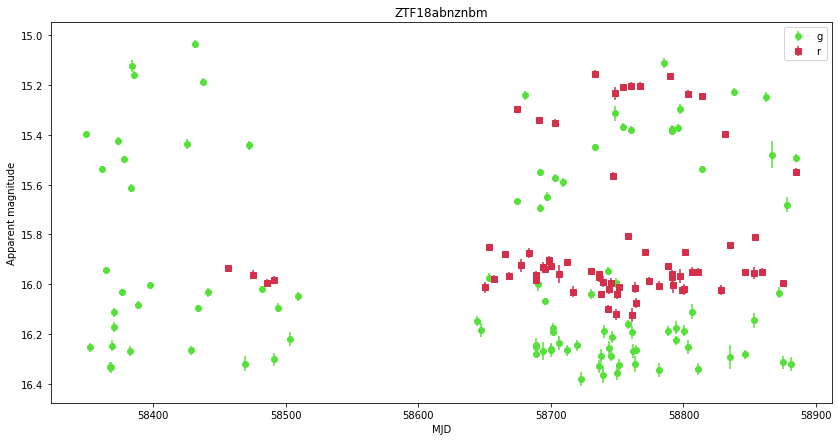

In [15]:
results = getVSdata(seloid, doLC=True, dostamp=False, dosimbad=False)

The first detections of this light curve were obtained on the Aug 19th 2018 (g filter) and Dec 4th 2018 (r filter).

## Extinction corrected light curve <a class="anchor" id="advancedlightcurve"></a>

We will correct the light curve from extinction using extinction mapping. For this purpose we will modify the above light curve using a dictionary with attenuations due to Galactic extinction. This will allow us to get absolute magnitudes (assuming no K-corrections) in restframe days. Note that we use astroquery Distance and WMAP7 objects, as well as mag units.

In [16]:
def plotLCcorr(oid, VS_det, VS_nondet, A=None):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    #colors = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = VS_det.fid == fid
        if np.sum(mask) > 0:
            
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            # plot attenuated light curve with small alpha
            ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr, 
                yerr = VS_det[mask].sigmapsf_corr_ext, c = colors[fid], marker = markers[fid], label = labels[fid], alpha=0.1, linestyle = 'None')
            # show dust attenuation corrected light curve
            ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr - A_fid, 
                yerr = VS_det[mask].sigmapsf_corr_ext, c = colors[fid], marker = markers[fid], label = "%s (ext. corr.)" % labels[fid], linestyle = 'None')
    
            
    # labels
    if A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]))
    else:
        ax.set_title(oid)
        
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

We will also modify the getVSdata function to get all the necessary information given the object id (oid). It now does the following:
 - get the basic VS statistics, this includes the position in the sky (using the ALeRCE client)
 - get the detections and non detections (using the ALeRCE client)
 - get the dust attenuation at the given position in the sky (using astroquery IrsaDust)
 - plot the apparent magnitude LC corrected for dust attenuation (using the previously defined function)
 - plot the absolute magnitude LC correction for dust and distance attenuation, in restframe time and ignoring k-corrections (using the previously defined plotLC function)
 - plot the first image stamps associated to this VS (using the ALeRCE client)

In [17]:
def getVSdatacorr(oid, doLC=False, doext=False, dostamp=False, dosimbad=False):

    results = {"oid": oid}
    
    # query basic stats
    VS_stats = client.query_object(oid, format='pandas')
    #display(VS_stats)
    results["stats"] = VS_stats
    
    # query magnitude stats
    VS_magstats = client.query_magstats(oid, format='pandas')
    results["magstats"] = VS_magstats
    
    # query detections
    VS_det = client.query_detections(oid, format='pandas')
    VS_det = VS_det.sort_values("mjd")
    results["lc_det"] = VS_det
        
    # query non detections
    VS_nondet = client.query_non_detections(oid, format='pandas')
    VS_nondet = VS_nondet.sort_values("mjd")
    results["lc_nondet"] = VS_nondet
    
    # object coordinates
    co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg), frame='icrs')
    
    # get SIMBAD query
    if dosimbad:
        Simbad_table = Simbad.query_region(co, radius=0.01 * u.deg, equinox=2000)
        display(Simbad_table)
        results["simbad_table"] = Simbad_table
    
    # get galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]), "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A

    # plot the LC
    if doLC:
        if doext:
            plotLCcorr(oid, VS_det, VS_nondet, A)
        else:
            plotLCcorr(oid, VS_det, VS_nondet)        
    
    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))
    
    # show the first image stamp
    if dostamp:
        client.plot_stamp(oid, results["lc_det"].candid.min())
        
    # return data
    return results

And now we can show the extinction corrected light curve and its stamp :

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
V* V420 Peg,00 00 18.1975,+19 32 55.448,14,14,0.051,0.024,90,A,O,2018yCat.1345....0G


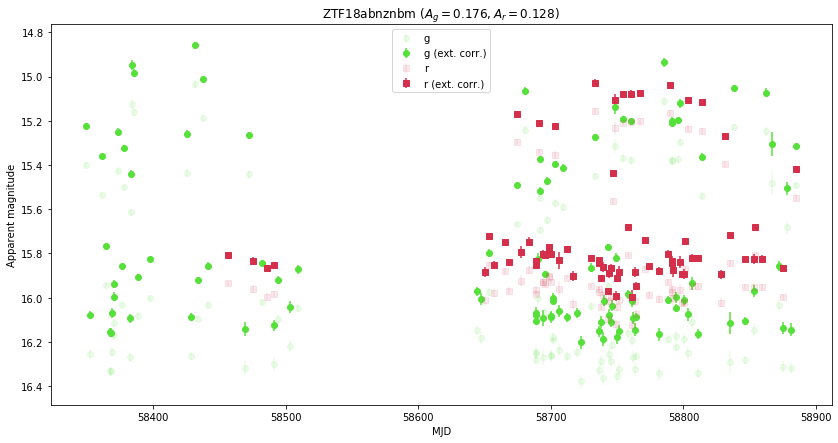

In [18]:
results = getVSdatacorr(seloid, doLC=True, doext=True, dostamp=True, dosimbad=True);

## Simple period <a class="anchor" id="simpleperiod"></a>

Because RRL are variable objects, the light curves shown above are not too informative, thus we will plot the folded light curve and obtain three different periodograms, the multiband period, the period in the g filter, and in the r filter.

We will use P4J to calculate the periodograms (https://github.com/phuijse/P4J). P4J is a python package for period detection on irregularly sampled and heteroscedastic time series based on Information Theoretic objective functions. P4J was developed for astronomical light curves, irregularly sampled time series of stellar magnitude or flux. The core of the used package is a class called periodogram that sweeps an array of periods/frequencies looking for the one that maximizes a given criterion. The main contribution of this work is a criterion for period detection based on the maximization of Cauchy-Schwarz Quadratic Mutual Information (Huijse et al., 2017). Information theoretic criteria incorporate information on the whole probability density function of the process and are more robust than classical second-order statistics based criteria (Principe, 2010). For comparison P4J also incorporates other period detection methods used in astronomy such as the Phase Dispersion Minimization periodogram (Stellingwerf, 1973), Lafler-Kinman's string length (Clarke, 2002) and the Orthogonal multiharmonic AoV periodogram (Schwarzenberg-Czerny, 1996).



First we define the function to get the period of the star :

In [19]:
def doperiod_multiband(VS_det):
    
    mjds, mags, errs, fids = VS_det[["mjd", "magpsf_corr", "sigmapsf_corr_ext", "fid"]].dropna().values.T
    
    # Compute periodogram
    my_per = P4J.MultiBandPeriodogram(method='MHAOV')
    #my_per = P4J.MultiBandPeriodogram()
    
    my_per.set_data(mjds, mags, errs, fids)        
    my_per.frequency_grid_evaluation(fmin=1e-3, fmax=20.0, fresolution=1e-3)
    #my_per.frequency_grid_evaluation(fmin=0.001, fmax=5., fresolution=1e-4)
    
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
    #my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=1)
    
    best_freq, best_per = my_per.get_best_frequencies()
    freq_mb, per_mb = my_per.get_periodogram()
    
    period_mb = 1.0 / best_freq[0]
    #best_freq = freq_mb[np.argmax(per_mb)]
    #period_mb = 1. / best_freq
    
    print('Multiband period: %.3f days' % period_mb)
    
    period = {}
    freq = {}
    per = {}
    labels = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        freq[fid], per[fid] = my_per.get_periodogram(fid)
        best_freq = my_per.get_best_frequency(fid)
        #best_freq = freq[fid][np.argmax(per[fid])]
        period[fid] = 1. / best_freq
        print("Period %s: %.3f days" % (labels[fid], period[fid]))
    
    return period_mb, freq_mb, per_mb, period, freq, per

Now define the function to be plotted:

In [20]:
def plotperiod_multiband(oid, VS_det, VS_nondet, dofold=False,
                         period_mb=None, freq_mb=None, per_mb=None,
                         period=None, freq=None, per=None):

    fig, ax = plt.subplots(figsize = (12, 6))
    labels = {1: 'g', 2: 'r'}
    #colors = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    for idx, fid in enumerate([1, 2]):
        maskdet = VS_det.fid == fid
        masknondet = (VS_nondet.fid == fid) & (VS_nondet.diffmaglim > -900)
        
        if dofold:
            phase = np.mod(VS_det[maskdet].mjd, period_mb) / period_mb
            for nphase in [0, 1]:
                if nphase == 0:
                    label = labels[fid]
                else:
                    label = None
                ax.errorbar(phase + nphase, VS_det[maskdet].magpsf_corr, 
                        yerr = VS_det[maskdet].sigmapsf_corr_ext, c = colors[fid], marker = markers[fid], label = label,
                        markersize=5, linestyle = 'None')
        else:
            ax.errorbar(VS_det[maskdet].mjd, VS_det[maskdet].magpsf_corr, 
                    yerr = VS_det[maskdet].sigmapsf_corr_ext, c = colors[fid], marker = markers[fid], label = labels[fid],
                    linestyle = 'None')
            ax.scatter(VS_nondet[masknondet].mjd, VS_nondet[masknondet].diffmaglim, c = colors[fid], alpha = 0.5,
                    marker = 'v', label = "lim.mag. %s" % labels[fid], linestyle = 'None')

    if dofold:
        ax.set_title("%s (multiband period: %.3f days)" % (oid, period_mb))
        ax.set_xlabel("phase")
    else:
        ax.set_title(oid)
        ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    if dofold:
        fig, ax = plt.subplots(ncols = 3, figsize = (12, 4))
        
        for idx, fid in enumerate([0, 1, 2]):
            if idx==0:
                ax[idx].plot(freq_mb, per_mb)
                ax[idx].set_title("Multiband periodogram")
                ax[idx].set_xlabel("frequency [1/days]")
            else:
                ax[idx].plot(freq[fid], per[fid])
                ax[idx].set_title("Periodogram %s (period: %.3f days)" % (labels[fid], period[fid]))
                ax[idx].set_xlabel("frequency [1/days]")

Get data, fold, and plot:

In [21]:
def getLCdata(oid, doplot=False, dofold=False):
    results = getVSdata(oid, doLC=False, dostamp=False, dosimbad=True)
    if dofold:
        # get period
        period_mb, freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"])
    else:
        period = None; freq = None; per = None
        period_mb = None; freq_mb = None; per_mb = None
    
    if doplot:
        plotperiod_multiband(oid, results["lc_det"], results["lc_nondet"], dofold,
                             period_mb=period_mb, freq_mb=freq_mb, per_mb=per_mb,
                             period=period, freq=freq, per=per)
        
    # return data
    return results

We can plot the folded light curve and periodograms, and the respective periods are shown:

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
V* V420 Peg,00 00 18.1975,+19 32 55.448,14,14,0.051,0.024,90,A,O,2018yCat.1345....0G


Multiband period: 0.545 days
Period g: 0.545 days
Period r: 0.545 days


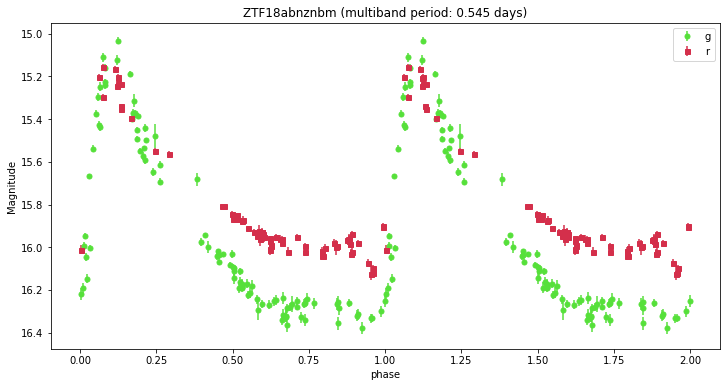

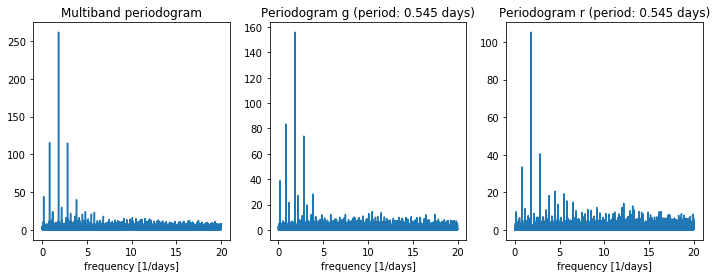

In [22]:
periodogram = getLCdata(seloid, doplot = True, dofold = True)

We estimated the period using the multiband periodogram, as well as individual periodograms for the filters g and r, and in all cases we obtained Period = 0.545 days. If we compare with the work by Drake et al. (2013), they obtained Period = 0.5454725 days, thus in very good agreement.

This RRL is also present in ASAS-SN: https://asas-sn.osu.edu/variables/ebab1536-9eea-5846-8981-6937bc875eb2 which shows results in very good agreement with those reported here.

From our analysis, we can state that this is an ab-type RR Lyrae star, as noted by its typical sawtooth-shaped light curve, period of order half a day, fast rise time (time between minimum and maximum), and shock-related bump before minimum light. 
Note that the color (g-r) can be directly inferred from the g and r light curves. The resulting values are typical of an RR Lyrae star that is not heavily affected by extinction, and which changes smoothly as a function of phase, as expected for this class of pulsating stars.

## Query image from Aladin <a class="anchor" id="oneimage"></a>

We can show an image from Aladin to see the star and its environment. We will also cross-match with Simbad.

In [23]:
info = widgets.HTML()

def process_objectHovered(data):
    
    output = '<font color="red">'
    # SIMBAD
    if data["data"]["cat_name"] == "Simbad":
        output = "<h2>Simbad</h2>"
        sel_keys = ["MAIN_ID", "RA", "DEC"]
    for key in sel_keys:
        if key in data["data"].keys():
            output += "<p><font size='1'>%s: %s</p>" % (key, data["data"][key])
    info.value =  '%s' % output

In [24]:
def show_image(results):
    aladin= ipyal.Aladin(target='%s %s' % (float(results["stats"].meanra), float(results["stats"].meandec)), 
                fov=0.04, survey='P/PanSTARRS/DR1/color-z-zg-g',
                reticle_size= 64,
                layout=Layout(width='70%'))
    box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='100%')
    box = Box(children=[aladin, info], layout=box_layout)
    display(box)
    if results["simbad_table"]:       
        results["simbad_table"]["cat_name"] = Column(["Simbad"], name="cat_name")   
        aladin.add_table(results["simbad_table"])
    aladin.add_listener('objectHovered', process_objectHovered)
    print("Hover mouse to see information about catalog objects")

And we can show the Aladin image:

In [25]:
show_image(results)

Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

Hover mouse to see information about catalog objects


# Query a sample of targets <a class="anchor" id="sampletarget"></a>

As explained in the [Introduction](#intro), ALeRCE systematically classifies the sources into a hierarchical taxonomy, based on a stamp classifier which classifies in five subclasses, and a light curve classifier that is used when at least six detections are obained in the light curve, which provides a more detailed classification up to 15 classes. We will briefly describe these classifiers, and we will show three different examples using the ALeRCE client and the database to query different samples of variable stars.

## Classifiers, taxonomies and numeric mappings in ALeRCE <a class="anchor" id="classifiers"></a>

There are two classifiers used in ALeRCE:

1. A stamp based classifier (Carrasco-Davis et al. 2020), which classifies objects based on their first image stamps. The purpose of this classifier is to differentiate five different classes between Active Galactic Nucleus (AGN), Supernovae (SN), variable star (VS), asteroid, or bogus.
2. A light curve based classifier (Sánchez-Sáez et al. 2020), which classifies objects based on their light curve. The purpose of this classifier is to provide a more refined classification starting with at least 6 detections in a given band.

Each classifier has its own taxonomy, which is more refined for the light curve classifier. Each class has numerical mappings. You can use their string or integer names when query the database.

The stamp classifier contains the following classes (see the image in [Introduction](#intro)):

*    `AGN`
*    `SN`
*    `VS`
*    `asteroid`
*    `bogus`
    
The light curve classifier uses the light curve information and contains the following classes (see the image in [Introduction](#intro)):

* `SNIa`
* `SNIbc`
* `SNII`
* `SLSN`
* `QSO`
* `AGN`
* `Blazar`
* `CV/Nova`
* `YSO`
* `LPV`
* `E`
* `DSCT`
* `RRL`
* `CEP`
* `Periodic-Other`

## Examples on how to use the ALeRCE client and database<a class="anchor" id="examplesample"></a>

In the following, we will explore three different options to query data from ALeRCE:

- [Using the ALeRCE client to study a sample of RRL taken from their oid](#liuetal)

- [Using the ALeRCE client to query a sample of RRL](#clientrrl)

- [Using the ALeRCE database (DB) to query a sample of RRL. Note that the DB allows more complex queries](#dbrrl)

### Using the ALeRCE client to study a sample of RRL from their oid <a class="anchor" id="liuetal"></a>

In this example, we want to use the sources in the sample of Liu et al. (2020) with available data in ALeRCE to estimate their distances. From their sample of 21 RRL, six have data in the g or r filter, and four have data in both the g and r filters, thus in the following we will use these four RRL.

In this example we will use the ALeRCE client to query the sources. If you are not yet connected to the ALeRCE client, jumt to [how to connect](#client).

First, we manually define the object identities of the sources we want to explore:

In [26]:
#seloid = ["ZTF17aabulmo", "ZTF18aajusiz", "ZTF18aalarzm", "ZTF18abiwdfa", "ZTF18aapmpdr", "ZTF18aapsyhm"] these are the six sources with data in g or r
seloid = [ "ZTF18aajusiz", "ZTF18aalarzm", "ZTF18aapmpdr", "ZTF18aapsyhm"] # these are the four RRL with data in both g and r

#### Plot the light curves <a class="anchor" id="samplelightcurve"></a>

We can plot their light curves :

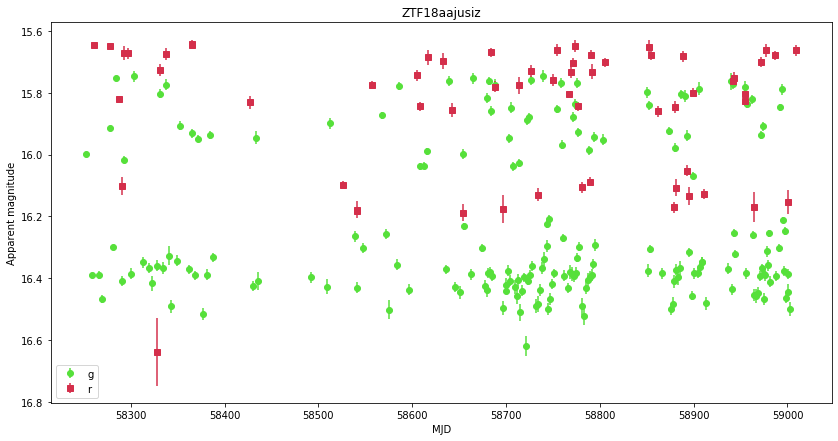

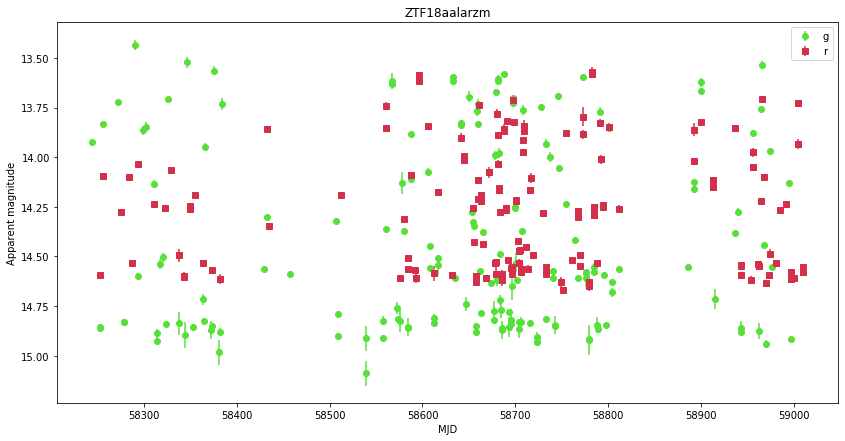

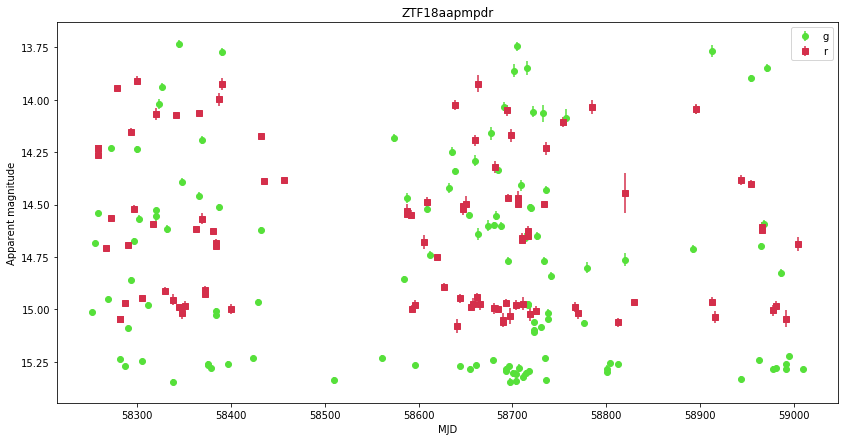

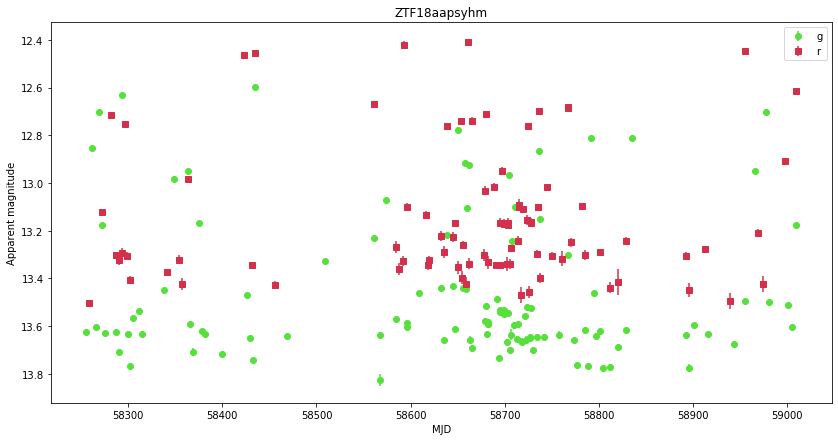

In [27]:
for oid in seloid:
    getVSdata(oid, doLC = True,  dostamp=False, dosimbad=False);

#### Plot the extinction corrected light curves <a class="anchor" id="sampleextlightcurve"></a>

As well as their light curves corrected for extinction along with their stamps :

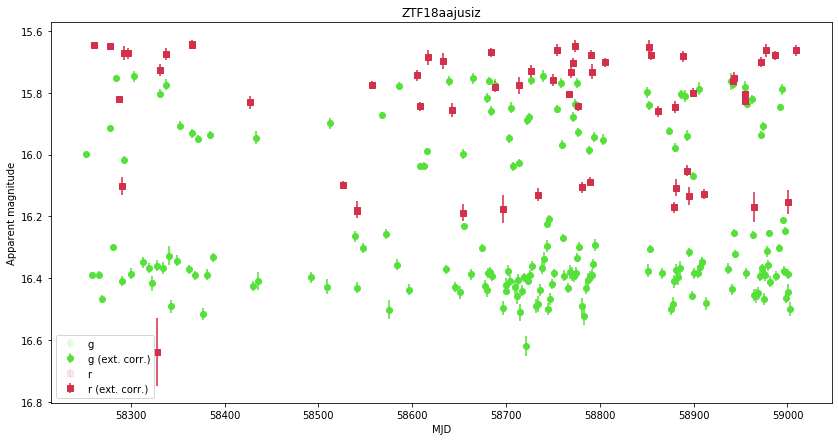

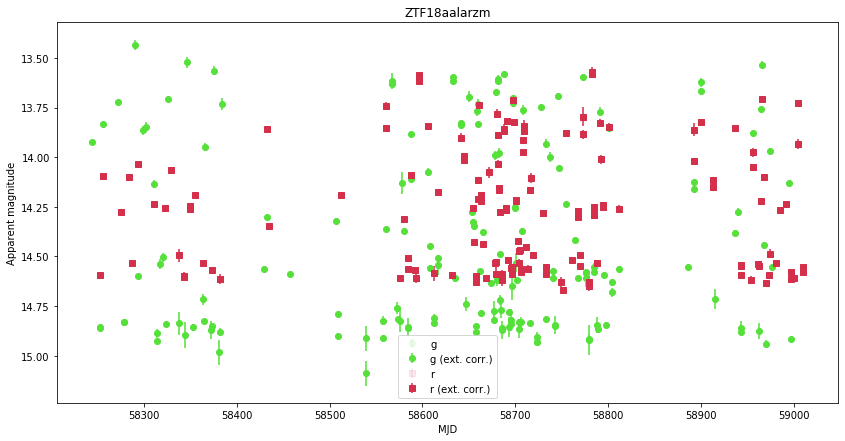

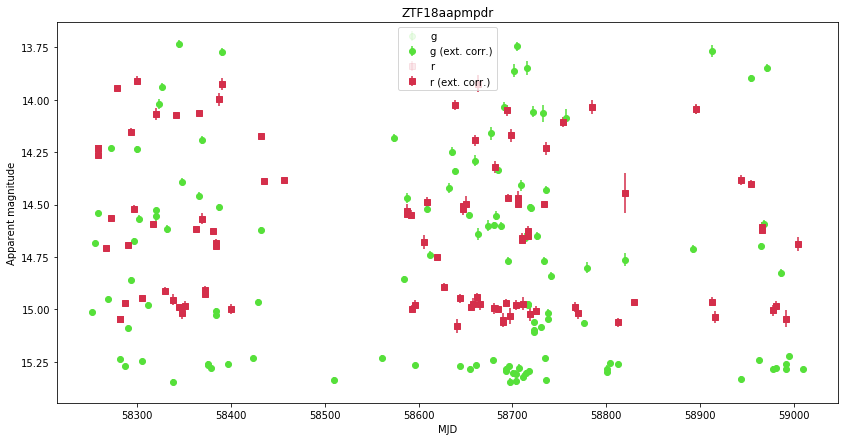

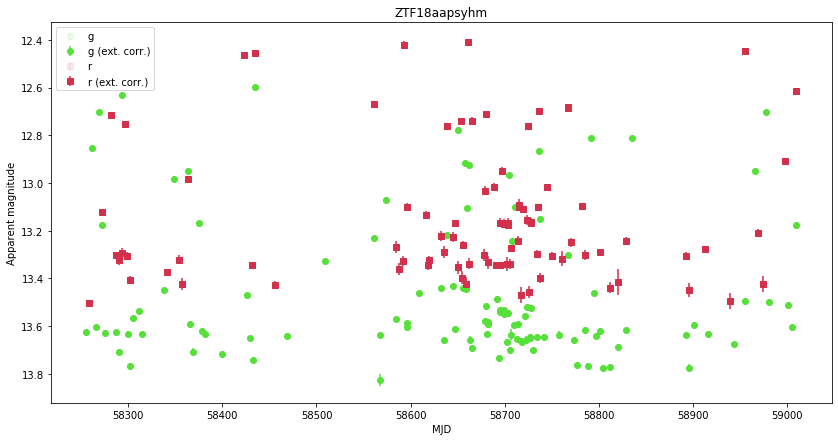

In [28]:
for oid in seloid:
    getVSdatacorr(oid, doLC = True,  dostamp=True, dosimbad=False);

#### Plot the folded light curves and periodograms <a class="anchor" id="samplefoldedlightcurve"></a>

And we also plot the folded light curves and periodograms, and estimate their periods :

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
2MASS J17073392+5850598,17 07 33.9321,+58 50 59.711,14,14,0.033,0.034,90,A,O,2018yCat.1345....0G


Multiband period: 0.679 days
Period g: 0.679 days
Period r: 0.679 days


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
V* V355 Lyr,18 53 25.9146,+43 09 16.416,14,14,0.017,0.022,90,A,O,2018yCat.1345....0G


Multiband period: 0.474 days
Period g: 0.474 days
Period r: 0.474 days


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
V* V1104 Cyg,19 18 00.4921,+50 45 17.810,14,14,0.023,0.022,90,A,O,2018yCat.1345....0G


Multiband period: 0.436 days
Period g: 0.436 days
Period r: 0.357 days


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
V* V894 Cyg,19 33 00.9070,+46 14 22.883,14,14,0.015,0.016,90,A,O,2018yCat.1345....0G
BOKS 3771,19 33 02.0846,+46 14 28.032,14,14,0.085,0.085,90,A,O,2018yCat.1345....0G


Multiband period: 0.571 days
Period g: 0.571 days
Period r: 0.571 days


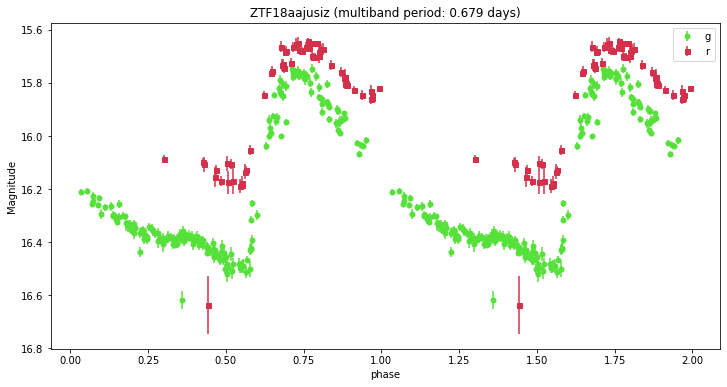

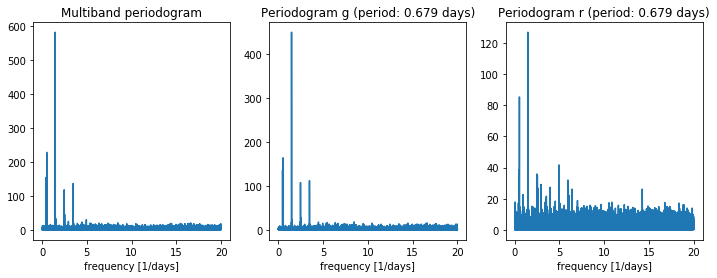

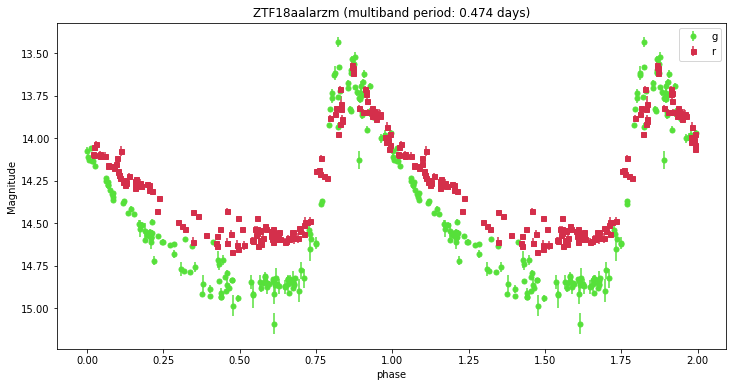

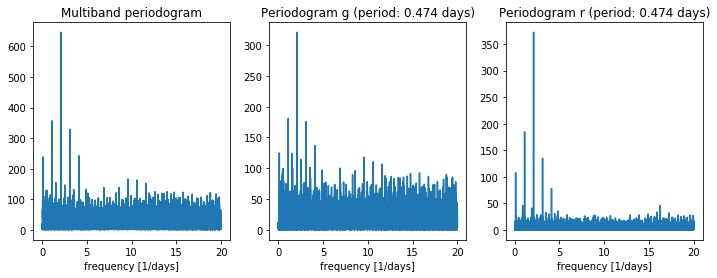

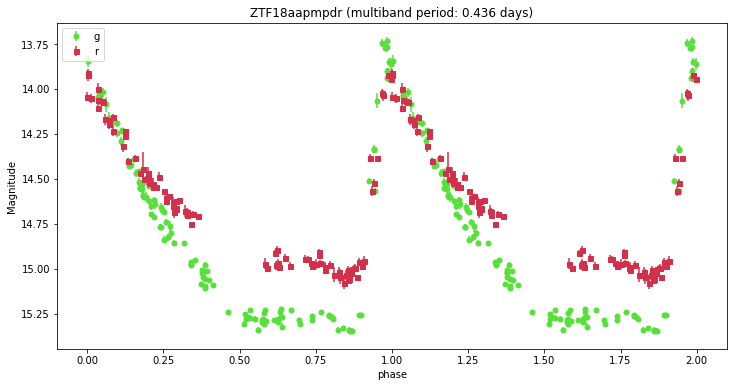

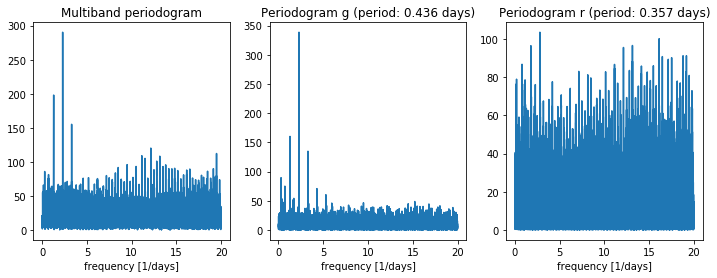

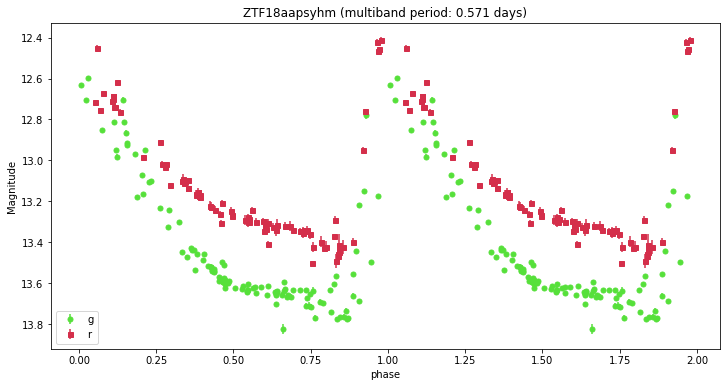

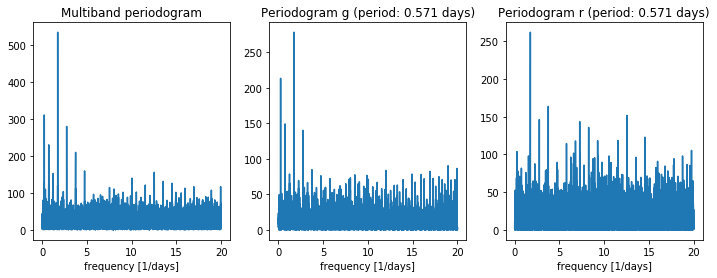

In [29]:
for oid in seloid:
    results = getLCdata(oid, doplot = True, dofold = True);

add text about multiband and band periods

#### Query images from Aladin <a class="anchor" id="sampleimage"></a>

We can also query their images from Aladin and get information from Simbad for each of the targets :

In [30]:
for oid in seloid:
    results = getLCdata(oid, doplot = False, dofold = False);
    show_image(results)

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
2MASS J17073392+5850598,17 07 33.9321,+58 50 59.711,14,14,0.033,0.034,90,A,O,2018yCat.1345....0G


Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

Hover mouse to see information about catalog objects


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
V* V355 Lyr,18 53 25.9146,+43 09 16.416,14,14,0.017,0.022,90,A,O,2018yCat.1345....0G


Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

Hover mouse to see information about catalog objects


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
V* V1104 Cyg,19 18 00.4921,+50 45 17.810,14,14,0.023,0.022,90,A,O,2018yCat.1345....0G


Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

Hover mouse to see information about catalog objects


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
V* V894 Cyg,19 33 00.9070,+46 14 22.883,14,14,0.015,0.016,90,A,O,2018yCat.1345....0G
BOKS 3771,19 33 02.0846,+46 14 28.032,14,14,0.085,0.085,90,A,O,2018yCat.1345....0G


Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

Hover mouse to see information about catalog objects


### Estimate distances using the intensity-mean magnitude <a class="anchor" id="distances"></a>

We will estimate the distance of the stars in the sample using the g and r filter and compare the distances. We will use the distance modulus (m - M) to obtain the distance. Distance and flux are related for two sources A and B as:

$F_A/F_B = (d_B/d_A)^2$

The relation between magnitude and flux is given by:

$m_B - m_A = 2.5 \log (F_A / F_B)$ 

Assuming the same star at different distances, we can obtain the distance as:

$d = 10^{0.2 (m - M + 5)}$ [pc]


where the apparent magnitude, m, is taken from the ZTF data (mean_magpsf_corr) which has been corrected for extinction. The absolute magnitude, M, is calculated following Catelan et al. (private communication), as follows:





$M_g = 1.646 + 0.307 * \log(Z)$

$M_r = 1.097 - 0.587 * \log(P) + 0.238 * \log(Z) $

where P refers to the period (in days), and $\log (Z)$ is estimated as:

$log(Z) = [M/H] - 1.765 = [Fe/H] + \log(0.638 * f + 0.362) - 1.765 $


where $ f = 10^{[\alpha/Fe]} $

Here $[Fe/H]$ has been obtained from Table 3 in Liu et al. (2020), and $[\alpha/Fe]$ can be considered $\sim$ +0.3 because because these stars have $[Fe/H] < \sim -$1 dex (Catelan et al., in prep.)

In [31]:
#feh = [-1.37, -2.92, -1.14, -2.54, -1.23, -1.66]
#feherr = [0.12, 0.0, 0.17, 0.11, 0.15, 0.12]
print(seloid)
feh = [-2.92, -1.14, -1.23, -1.66]
afe = 0.3
f = 10**afe
print("f =",f)
mh = feh + np.log(0.638 * f + 0.362)
print("[M/H] =",mh)
logZ = mh-1.765
print("log(Z) =",logZ)

Mg = 1.646 + 0.307 * logZ
print("Absolute Magnitude g, M_g", Mg)

mg = np.empty(len(seloid))
mr = np.empty(len(seloid))
period_mb = np.empty(len(seloid))
for i in range(len(seloid)):
    results = getVSdatacorr(seloid[i], doext=True, doLC = False,  dostamp=False);
    #mg[i] = results["stats"].mean_magpsf_g - results["attenuation"]["g"]
    mg[i] = results["magstats"].magmean[0] - results["attenuation"]["g"]
    mr[i] = results["magstats"].magmean[1] - results["attenuation"]["r"]
    period_mb[i], freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"])

Mr = 1.097 - 0.587 * np.log(period_mb) + 0.238 * logZ  
print("Absolute Magnitude r, M_r", Mr)   
    
    

#Mr = 1.097 - 0.587 * log(P) + 0.238 * logZ

print("Apparent Magnitude g, m_g",mg)

#Estimate distance using the m-d distance


dist_g = 10**(0.2 * (mg - Mg + 5.0))
print("Distance g filter (pc) = ", dist_g)

dist_r = 10**(0.2 * (mr - Mr + 5.0))
print("Distance r filter (pc) = ", dist_r)

['ZTF18aajusiz', 'ZTF18aalarzm', 'ZTF18aapmpdr', 'ZTF18aapsyhm']
f = 1.9952623149688795
[M/H] = [-2.42837104 -0.64837104 -0.73837104 -1.16837104]
log(Z) = [-4.19337104 -2.41337104 -2.50337104 -2.93337104]
Absolute Magnitude g, M_g [0.35863509 0.90509509 0.87746509 0.74545509]


Multiband period: 0.679 days
Period g: 0.679 days
Period r: 0.679 days


Multiband period: 0.474 days
Period g: 0.474 days
Period r: 0.474 days


Multiband period: 0.436 days
Period g: 0.436 days
Period r: 0.357 days


Multiband period: 0.571 days
Period g: 0.571 days
Period r: 0.571 days
Absolute Magnitude r, M_r [0.32636343 0.96122918 0.98794164 0.72745288]
Apparent Magnitude g, m_g [17.555593 15.543545 16.059022 14.661199]
Distance g filter (pc) =  [27503.7291251   8466.22843022 10872.04852596  6069.44223082]
Distance r filter (pc) =  [30452.24491954  9416.99119169 10293.45742475  4524.02113229]


#### Plots of the sample properties <a class="anchor" id="sampleproperties"></a>

We define a function to plot different properties of the stars :

In [32]:
def plot_properties(propx, propy, propx_label, propy_label, dodiag=False):
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.scatter(propx, propy)
    ax.set_xlabel("%s" % propx_label)
    ax.set_ylabel("%s" % propy_label)
    
    if dodiag:
        t = np.arange(min(propx)-1, max(propx)+1, 0.01)
        s = t
        ax.plot(t, s,color='gray', linestyle='--',label="y=x")
        ax.legend()
    
    #ax.set_xlim(min(propx)-1, max(propx)+1)
    #ax.set_ylim(min(propy)-1, max(propy)+1)

We remind the properties that have been estimated in this section:


In [33]:
print("Absolute Magnitude g, M_g", Mg)
print("Absolute Magnitude r, M_r", Mr)   
print("Apparent Magnitude g, m_g",mg)
print("Apparent Magnitude r, m_r",mr)
print("Distance g filter (pc) = ", dist_g)
print("Distance r filter (pc) = ", dist_r)

Absolute Magnitude g, M_g [0.35863509 0.90509509 0.87746509 0.74545509]
Absolute Magnitude r, M_r [0.32636343 0.96122918 0.98794164 0.72745288]
Apparent Magnitude g, m_g [17.555593 15.543545 16.059022 14.661199]
Apparent Magnitude r, m_r [17.74446  15.83079  16.050748 14.005076]
Distance g filter (pc) =  [27503.7291251   8466.22843022 10872.04852596  6069.44223082]
Distance r filter (pc) =  [30452.24491954  9416.99119169 10293.45742475  4524.02113229]


And we want to compare the distances obtained for the two filters, so we select these variables to be plotted: 

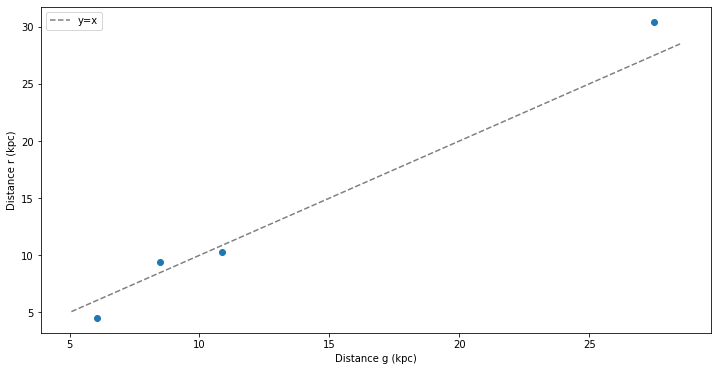

In [34]:
plot_properties(propx=dist_g/1000., propy=dist_r/1000., propx_label="Distance g (kpc)", propy_label="Distance r (kpc)", dodiag=True)

A good agreement is obtained for the distances.

Now we will plot the absolute and apparent magnitudes of the RRL against their maximum and mean colors, thus we obtain the colors from the "stats" table, that are corrected by extinction:

(17.715489300441504, 14.501302699558497)

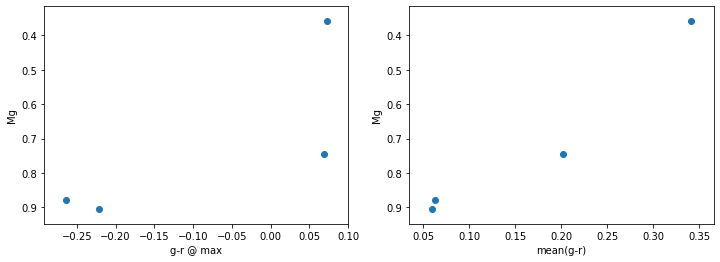

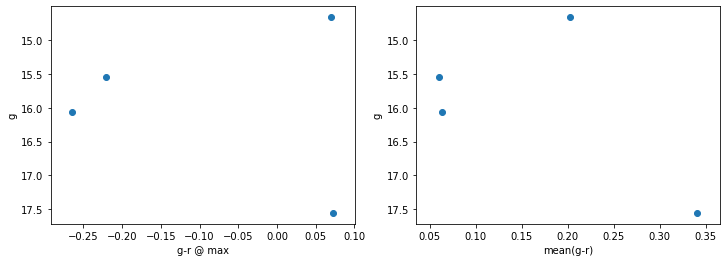

In [35]:
g_r_max_corr_ext_att = np.empty(len(seloid))
g_r_mean_corr_ext_att = np.empty(len(seloid))

for i in range(len(seloid)):
    results = getVSdatacorr(seloid[i], doext=True, doLC = False,  dostamp=False);
    g_r_max_corr_ext_att[i] = results["stats"].g_r_max_corr - results["attenuation"]["g"] + results["attenuation"]["r"]
    g_r_mean_corr_ext_att[i] = results["stats"].g_r_mean_corr - results["attenuation"]["g"] + results["attenuation"]["r"]

fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
ax[0].scatter(g_r_max_corr_ext_att, Mg)
ax[0].set_xlabel("g-r @ max")
ax[0].set_ylabel("Mg")
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[1].scatter(g_r_mean_corr_ext_att, Mg)
ax[1].set_xlabel("mean(g-r)")
ax[1].set_ylabel("Mg")
ax[1].set_ylim(ax[1].get_ylim()[::-1])

fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
ax[0].scatter(g_r_max_corr_ext_att, mg)
ax[0].set_xlabel("g-r @ max")
ax[0].set_ylabel("g")
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[1].scatter(g_r_mean_corr_ext_att, mg)
ax[1].set_xlabel("mean(g-r)")
ax[1].set_ylabel("g")
ax[1].set_ylim(ax[1].get_ylim()[::-1])

Finally, we will compare the periods obtained from the multiband period or from single band periods in g and r, thus we get the data from the function and plot both cases:

Multiband period: 0.679 days
Period g: 0.679 days
Period r: 0.679 days


Multiband period: 0.474 days
Period g: 0.474 days
Period r: 0.474 days


Multiband period: 0.436 days
Period g: 0.436 days
Period r: 0.357 days


Multiband period: 0.571 days
Period g: 0.571 days
Period r: 0.571 days


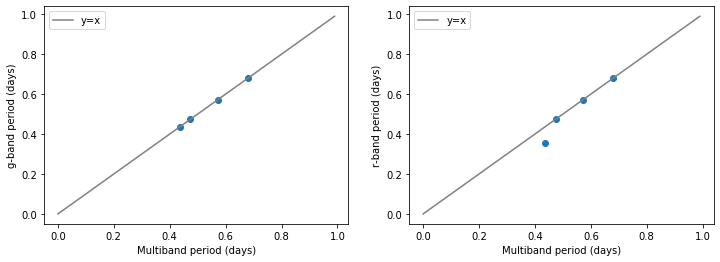

In [36]:
period_mb = np.empty(len(seloid))
period_band = np.empty((len(seloid), 2))

for i in range(len(seloid)):
    results = getVSdatacorr(seloid[i], doext=True, doLC = False,  dostamp=False);
    period_mb[i], freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"])
    period_band[i,0] = period[1]
    period_band[i,1] = period[2]

labels = {1: 'g', 2: 'r'}
t = np.arange(0.0, 1.0, 0.01)
s = t
fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
        
for idx, fid in enumerate([1, 2]):
    ax[idx].scatter(period_mb, period_band[:,fid-1])
    ax[idx].set_xlabel("Multiband period (days)")
    ax[idx].set_ylabel("%s-band period (days)" % (labels[fid]))
    ax[idx].plot(t, s, c='gray', label="y=x")
    ax[idx].legend()

The agreement is very good, except for one of the sources, ZTF18aapmpdr, where the period estimated from the r-filter is lower than the multiband period.

### Using the ALeRCE client to query a big sample of RRL <a class="anchor" id="clientrrl"></a>

In this example we will access the ALeRCE API to do a simple query to get information about a sample of targets with a probability of being classified as RRL by the light curve classifier larger than 0.9, that will be ordered by their probability. We will output the result of the query directly as a pandas dataframe :

In [ ]:
min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd + 70

VSs = client.query_objects(classifier="lc_classifier",
                           class_name="RRL", 
                           probability=0.9,
                           #ndet=[10, 50],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           page_size=500, format='pandas')
print(VSs.shape)
VSs.head()

Here you can see the fields available in the dataframe

In [ ]:
list(VSs)

So we can define a histogram to check the distributions of these parameters.

For example, here we show the distribution of the maximum g-r color:

In [ ]:
fig, ax = plt.subplots()
ax.hist(VSs.g_r_max, bins=50)
ax.set_xlabel("g-r @ max")

Or the number of detections for the sample of variable stars:

In [ ]:
fig, ax = plt.subplots()
VSs.ndet.plot.hist(ax=ax)
ax.set_xlabel("N. detections")

And will also plot these properties using the plot that we defined previously.

Here we show their mean corrected colors, g_r_mean_corr, versus their maximum corrected colors,  VSs.g_r_max_corr:

In [ ]:
plot_properties(propx=VSs.g_r_mean_corr, propy=VSs.g_r_max_corr,
                propx_label="mean(g-r)", propy_label="g-r @ max", dodiag=True)

As expected, the maximum colors are bluer that the mean values.

Finally, we show the images of the stars in the sample in Aladin.

In [ ]:
for oid in np.random.choice(VSs.oid, size=3):
    #print(oid)
    #getVSdatacorr(oid, doLC = True, doext=True, dostamp=True);
    results = getLCdata(oid, doplot = True, dofold = True);
    show_image(results)

### Using the ALeRCE database (DB) to query a sample of RRL <a class="anchor" id="dbrrl"></a>

The previous way of querying candidates is good for relatively simple queries. However, if we want to do more complex queries the best solution may be to connect directly to the DB. We show how to do this here. You will need to use the read only credentials available in the repository

In [ ]:
import json
credentials_file = "alercereaduser_v3.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

Now we open a connection to the DB

In [ ]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

And we show all the available tables

In [ ]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

You can see all the tables used in the new version of our database. The most relevant tables are, moving from less to more aggregation:

* `non_detection`: one row per non-detection per object, the limiting magnitudes
* `detections`: one row per detection, light curves and other relevant time dependent information
* `dataquality`: one row per detection, data quality related time dependent information
* `magstat`: one row per object per filter, statistics per bandpass per object
* `object`: one row per object, basic object statistics
* `probability`: one row per object per classifier and class, the probabilities of every object
* `reference`: one row per object per reference image, object statistics for every reference image used
* `feature`: one row per object per feature, object computed features
* `xmatch`: one row per object per external catalog, the table that points to the detailed xmatch tables
* `allwise, ps1_ztf, gaia_ztf, ss_stf`: one row per object, xmatch tables


For completeness, we now show all columns available in all tables :

In [ ]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

Now we can do a query asking for RRL candidates. For this it is important to understand the probability table. This table contains all the classifications probabilities, for every object, every classifier, and every available class. An object will be in many rows of this table, with the idea of being flexible to future changes in the taxonomy.
For example, an object classified by the light curve classifier (classifier_name=lc_classifier) will appear in all the available classes, e.g., class_name='SNIa' or class_name='AGN', independently of whether this is the most likely class. The most likely class can be quickly obtained with the ranking column (ranking=1). For example, if we want to find the probabilities of the objects most likely to be RR Lyrae, we would look for objects with classifier_name='lc_classifier', class_name='RRL' and ranking=1. The probabilities will be given by the probability column.

We will query objects that are most likely to be RRL (ranking<3) with a probability larger than 0.9.
For this we will do a complex query, including an inner join between object and probability and selecting those oids to be considered from probability.

In [ ]:
query='''
SELECT
    object.oid, object.meanra, object.meandec, object.ndet,
    object.firstMJD, object.deltajd, object.g_r_max,
    probability.classifier_name, probability.class_name,
    probability.ranking, probability.probability
FROM
    object INNER JOIN probability
    ON object.oid=probability.oid
WHERE
    probability.classifier_name='lc_classifier'
    AND object.oid IN 
(
SELECT
    oid
FROM
    probability
WHERE
    classifier_name='lc_classifier'
    AND class_name IN ('RRL')
    AND ranking<3
    AND probability > 0.9
)
'''

VSs = pd.read_sql_query(query, conn)
print(VSs.shape)
VSs.set_index('oid', inplace=True)
VSs.head()

Let's look at all the appearances of the first VS above:

In [ ]:
VSs.loc[VSs.iloc[[0]].index]

We will create a short function to convert the probabilities and rankings into columns, with one row per object. Note that this takes some time for variability classes like RRL!

In [ ]:
def merge_probs(df):
    dfnew = df.copy().iloc[[0]].drop(["class_name", "ranking", "probability"], axis=1)
    for cl in df.class_name.unique():
        mask = df.class_name == cl
        dfnew["%s_prob" % cl] = df.loc[mask].probability
        dfnew["%s_rank" % cl] = df.loc[mask].ranking
    return dfnew

In [ ]:
merge_probs(VSs.loc[VSs.iloc[[0]].index])

We see here that the result is only one row per oid.

You could apply it to the entire dataframe, but it can take too long, so we leave it commented...

In [ ]:
#VSprobs = VSs.groupby("oid").apply(merge_probs)
#VSprobs.reset_index(level=1, drop=True, inplace=True)
#VSprobs.head()

Here we show a list of the parameters in the table VSprobs, that you can uncomment in case you run the previous commands:

In [ ]:
#list(VSprobs)

Now we plot an histogram of the probabilities of the sources of being classified as RRL:

In [ ]:
fig, ax = plt.subplots()
mask = (VSs.ranking == 1) & (VSs.class_name == "RRL")
ax.hist(VSs.loc[mask].probability, bins=30)
ax.set_xlabel("RRL prob")

And the histogram of the "Rankings":

In [ ]:
fig, ax = plt.subplots()
mask = VSs.class_name == "RRL"
ax.hist(VSs.loc[mask].ranking, bins=30)
ax.set_xlabel("Ranking")

Here all the sources with a high probability of being RRL have Ranking=1.

Finally, we will plot the number of detections against the number of days since ZTF started to observe this source:

In [ ]:
plot_properties(propx=VSs.loc[mask].ndet, propy=VSs.loc[mask].deltajd, propx_label="N. detections", propy_label="Delta MJD")